# Predicting categories: logistic regression

In the past chapters we have seen how we could create an ML model to predict a **continuous** variable such as the price of an apartment. However very often we want to predict a category, i.e. a **discrete** value. Such a prediction is generally called **classification** and can be obtained by multiple methods. Here we will first have a loot at **logistic regression**, which is conceptually close to the linear regression seen before. We will first try to solve the problem with linear regression to understand why it is not a good solution.

## Data exploration

Here we will use again the wine dataset with the goal of answering the binary question "is the wine good or bad" based on the ```quality``` feature:

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')


We have a look at the distribution of the ```quality``` feature:

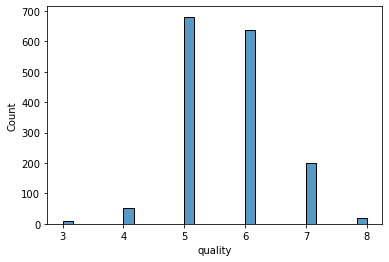

In [47]:
sns.histplot(wine['quality']);

To simplify the problem, for the moment we focus on extreme cases of very bad (quality <5) and very good wines (quality > 7) so we subselect some data:

In [48]:
wine = wine[(wine['quality']<5) | (wine['quality']>=7)]

Now we create a new column ```good_bad``` turning the ```quality``` information into a purely **binary** one. First we set all values to zero:

In [71]:
wine['good_bad'] = 1

Then we use indexing to turn 0s into 1s where the quality is larger than 6. To access the required values we use the ```loc``` property that gives us access to specific indices in the table:

In [73]:
wine.loc[wine['quality'] > 6, 'good_bad'] = 0

Now we can do a pairplot with a few features, but only as a function of ```good_bad```:

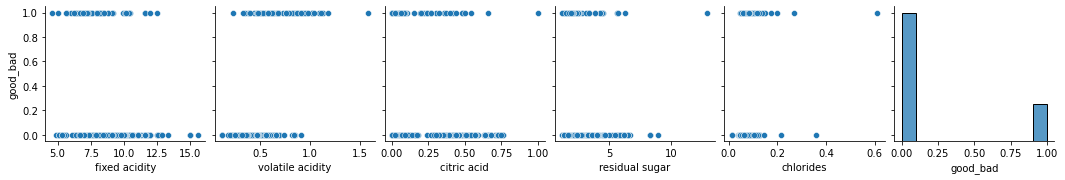

In [74]:
sns.pairplot(wine[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'good_bad']],
            y_vars='good_bad');
                   

Looking at the above plot, which variable could we try to use to predict quality? It looks like for example the ```volatile acidity``` is rather low for good quality wines and high for bad quality ones. We can have a look at a histogram: 

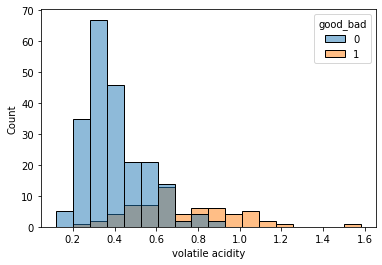

In [77]:
sns.histplot(data=wine, x='volatile acidity', hue='good_bad');

## Linear regression

Now our task is to predict the ```good_bad``` feature based on the ```volatile acidity``` feature:

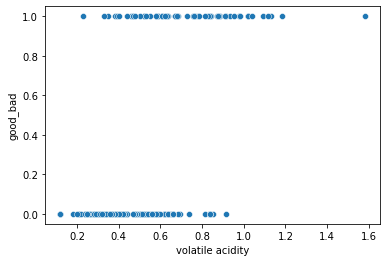

In [80]:
sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');

We can first resort to the tool we have seen previously with scikit-learn's LinearRegression:

In [81]:
from sklearn import linear_model

In [117]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X=wine[['volatile acidity']], y=wine['good_bad'])

pred = lin_model.predict(np.arange(0,1.6,0.1)[:, np.newaxis])

/Users/gw18g940/mambaforge/envs/EHML5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


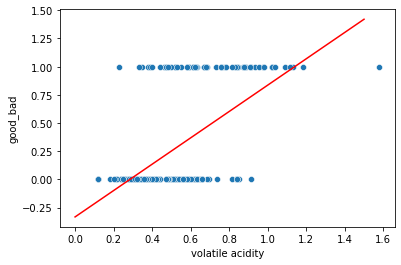

In [118]:
sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');
plt.plot(np.arange(0,1.6,0.1), pred, 'r');

We see that this model is really not appropriate. Of course we could set a limit at 0.5 and say that points below are good and those above bad, but problems remain. For example points with extreme values of acidity have a large weight in the error. 

A more appropriate solution would be to pass the linear model directly through a step function. Such a function $H(x, d)$ takes a value $x$ and returns 0 if $x<d$ and 1 if $x>d$. We can for example set this manually for our data:

In [119]:
def step(x, d):
    out = np.zeros(len(x))
    out[x>d] = 1
    return out

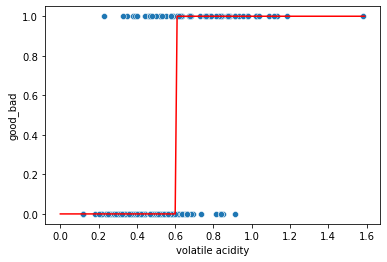

In [120]:
sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');
plt.plot(np.arange(0,1.6,0.01), step(np.arange(0,1.6,0.01), 0.6), 'r')

Now we just set the limit at 0.6 manually. However here too we would like to let the computer find the best threshold value. The problem with the above step function is that it's not usable for gradient descent. As we have seen previously, the idea of that method is to slightly vary the parameters of the function to find in which direction the error decreases. However here when we change the parameter ```d``` by a small amount, often nothing happens, as no point changes category. So the error landscape if flat and we don't know in which direction to go!

We have thus to come up with a better function to describe our data. One such function is the sigmoid, which looks like a step function with less sharp edges (the origin of this function can be explained statistically but this is beyond the scope of this course). The sigmoid can be defined with two parametere ```w``` which controls the steepness and ```d``` again the location:

In [121]:
def sigmoind(x, d, w):
    out = 1 / (1 + np.exp(-w*(x-d)))
    return out

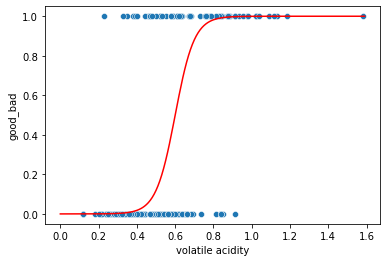

In [122]:
sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');
plt.plot(np.arange(0,1.6,0.01), sigmoind(np.arange(0,1.6,0.01), 0.6, 20), 'r');

Now we have a continous result: for exampel at the acidity value 0.6 the estimation is 0.5. This number actually offers a **probability** that a point belongs to the category ```1```: we are relatively sure that points on the far right belong to category ```1``` and those on the far left not (and thus belong to category ```0```) and for the points in the middle we are unsure.

The advantage of this function is that now if we slightly modify ```w``` or ```d```, the error will change **smoothly** and we will be able to estimate slopes for gradient descent!

In fact measuring the error simply as the sum of errors $\texttt{sigmoid}(x_i, d, w) - y_i$ is still not optimal (the slope is not zero but still very flat) and usually one uses another **metric** called the **cross entropy cost**.

## Logistic regression in scikit-learn

Now that we undersand why we can't use simple linear regression, let's have a look at how to do logistic regression in scikit-learn. Again we create the model and fit it with our data:

In [ ]:
log_model = linear_model.LogisticRegression()
log_model.fit(X=wine[['volatile acidity']], y=wine['good_bad'])

Now we can use our trained model for predictions. In this case we can both output the probabilities (the actual sigmoid curve) or directly the category:

In [156]:
pred_prob = log_model.predict_proba(np.arange(0,1.6,0.01)[:, np.newaxis])
pred = log_model.predict(np.arange(0,1.6,0.01)[:, np.newaxis])

/Users/gw18g940/mambaforge/envs/EHML5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


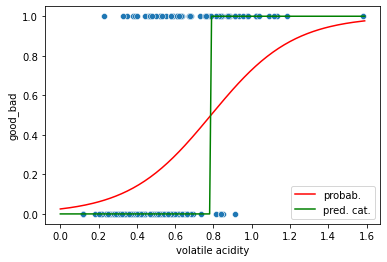

In [157]:
ax = sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');
ax.plot(np.arange(0,1.6,0.01), pred_prob[:,1], 'r', label='probab.')
ax.plot(np.arange(0,1.6,0.01), pred, 'g', label='pred. cat.')
ax.legend();

## Estimating the error

For the optimization, we use here by default the cross-entropy loss. This is useful because it provides us a smooth function that is practical for gradient descent. However the actual value that we get is difficult to understand intuitively. To estimate how good our model is, we instead e.g. want to count how many elements were classified properly.

For example we can subtract the actual from the predicted values:

In [167]:
predict_data = log_model.predict(wine[['volatile acidity']])

wine['good_bad'] - predict_data

7       0
8       0
16      0
18      1
37      0
       ..
1541    0
1544    0
1549    0
1555    0
1584    0
Name: good_bad, Length: 280, dtype: int64

Whenever we get 0 here, the prediction was accurate and whenever we get -1 or 1 we miss-classified. Let's first count bad predictions (we take the absolute values to count -1 as "bad"). We calculate as percentage of all data points:

In [184]:
100* np.sum(np.abs(wine['good_bad'] - log_model.predict(wine[['volatile acidity']]))) / len(wine)

16.428571428571427

And correctly classified:

In [185]:
100* np.sum((wine['good_bad'] - log_model.predict(wine[['volatile acidity']])) == 0) / len(wine)

83.57142857142857

So we have an accuracy of 83%. This seems quite good, but is it as good as it seems?

## Checking model quality

Instead of calculating the success of our model for each category separately. In other words, how good is the model at predicting good wines and bad wines separately. If we only select data points that should be either good or bad we can just count the correct instances:

In [176]:
np.sum(predict_data[wine['good_bad'] == 0] == 0)

211

or as a fraction:

In [186]:
100 * np.sum(predict_data[wine['good_bad'] == 0] == 0) / len(wine[wine['good_bad'] == 0])

97.23502304147465

So here in 97% of cases, when a wine is good, we predict that it's good. In contrast for bad wines:

In [187]:
np.sum(predict_data[wine['good_bad'] == 1] == 1)

23

In [237]:
np.sum(predict_data[wine['good_bad'] == 1] == 0)

40

In [188]:
100 * np.sum(predict_data[wine['good_bad'] == 1] == 1) / len(wine[wine['good_bad'] == 1])

36.507936507936506

We only predict in 36% of cases that a wine is bad when it's actually bad.

We can compute these errors in one go with scikit-learn using a **confusion matrix**. Such a matrix will indicate us how many items were in-/correctly classified for each category. We just have to pass actual and predicted values to the function:

In [189]:
from sklearn.metrics import confusion_matrix

In [190]:
confusion_matrix(wine['good_bad'], predict_data)

array([[211,   6],
       [ 40,  23]])

We see here again the numbers that we obtained before: 211 and 23 represents the correctly classified items for each category. 40 and 6 represent badly classified ones. Each of these four elements usually has a name. If we consider "classify as good" a positive outcome and "classify as bad" a negative outcome, then classifying an actual good wine as good is a **True Positive (TP)**, classifying a good wine as bad is a **False Negative** etc. You can see all combinations in the figure below:

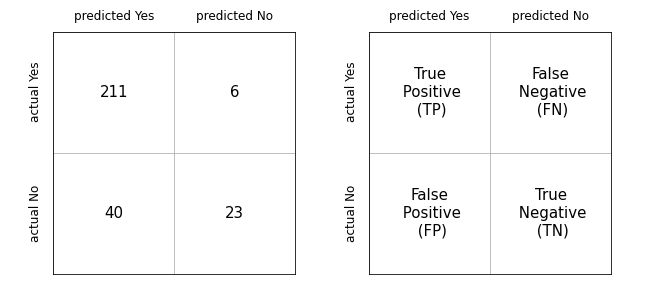

In [257]:
from IPython.display import display, Image
display(Image('images/confusion.png'))

The accuracy that we have measured before consist now in fact of summing up the diagonal and dividing by the total number of data points: $\texttt{accuracy} = \frac{TP + TN}{TP+TN+FP+FN}$. We will see in a later section that we can come up with better metrics mixing these variables. In the meantime, let's try to improve our model.

## Imbalance

Why is our model so good at predicting good wines but not bad wines? The reason is that we have a strong imbalance between the two categories:

In [261]:
f'Number of good wines: {len(wine[wine["good_bad"]==0])}'

'Number of good wines: 217'

In [262]:
f'Number of bad wines: {len(wine[wine["good_bad"]==1])}'

'Number of bad wines: 63'

Let's imagine what would happen if we had even less examples of bad wines, e.g. just 2. Then if the model is really dumb and **always** predicts that any wine is good, it would be correct in 99% of cases, without any effort! In such a case, we have to tell the ML model "be careful and be very attentive to these rare cases when learning!". The way to do this is to give different **weights** to categories when computing the loss. 

A common solution is to give weights inversely proportional to the number of occurrences e.g. 1/217 and 1/63. For the logistic regression we have to pass a list of per-sample weights. We can do this by adding a column to the dataset:

In [267]:
weights = 1/wine['good_bad'].value_counts()

In [275]:
wine['good_bad']==0

7        True
8        True
16       True
18      False
37       True
        ...  
1541     True
1544     True
1549     True
1555     True
1584     True
Name: good_bad, Length: 280, dtype: bool

In [278]:
wine['weight'] = 1
wine.loc[wine['good_bad']==0, 'weight'] = weights[0]
wine.loc[wine['good_bad']==1, 'weight'] = weights[1]

Let's try to use this during the fit:

In [280]:
log_model = linear_model.LogisticRegression()
log_model.fit(X=wine[['volatile acidity']], y=wine['good_bad'], sample_weight=wine['weight'])

LogisticRegression()

/Users/gw18g940/mambaforge/envs/EHML5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


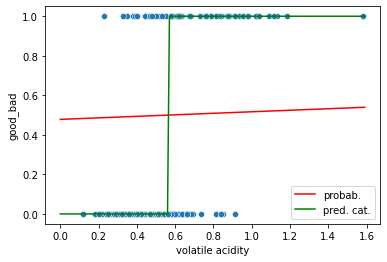

In [281]:
pred_prob = log_model.predict_proba(np.arange(0,1.6,0.01)[:, np.newaxis])
pred = log_model.predict(np.arange(0,1.6,0.01)[:, np.newaxis])

ax = sns.scatterplot(data=wine, x='volatile acidity', y='good_bad');
ax.plot(np.arange(0,1.6,0.01), pred_prob[:,1], 'r', label='probab.')
ax.plot(np.arange(0,1.6,0.01), pred, 'g', label='pred. cat.')
ax.legend();

In [282]:
predict_data = log_model.predict(wine[['volatile acidity']])

confusion_matrix(wine['good_bad'], predict_data)

array([[182,  35],
       [ 16,  47]])

In [283]:
print('True negative rate')
100 * np.sum(predict_data[wine['good_bad'] == 1] == 1) / len(wine[wine['good_bad'] == 1])

True negative rate


74.60317460317461

In [284]:
print('True positive rate')
100 * np.sum(predict_data[wine['good_bad'] == 0] == 0) / len(wine[wine['good_bad'] == 0])

True positive rate


83.87096774193549

We see that we managed to massively improve the number of negatives that we predict correctly, at a minor cost for the prediction of true positives!

Such weights are used very often in almost any method, including e.g. Deep Learning. For example you could imagine trying to detect tiny objects in a large image. In such a case you would need to give a large weight to pixels corresponding to the tiny objects.

## Other metrics

We have seen before that we could define the True/False Positive/Negative quantities. We also saw that we could use these variables to define quality metrics such as the $\texttt{accuracy} = \frac{TP + TN}{TP+TN+FP+FN}$.

We can however define other variables that are commonly used in machine learning. Two of the most important ones are **precision** and **recall**. The precision, as the name says, indicates how precise our model is: it tells us the fraction of positives which are actually true positives and not false positives and is defined as $\texttt{precision} = \frac{TP}{TP+FP}$. The recall tells us if we are missing a lot of positives because we miss some as false negatives and is defined as $\texttt{recall} = \frac{TP}{TP+FN}$. Ideally we would like to have high precision, i.e. as few FPs as possible. But this doesn't say anything about the number of TP that we have: we could have very few TP and FP and still have high precision. So we need to also look at recall and have a recall as high as possible too, i.e. as few FN as possible.

Let's consider a simple example where we classify pictures of cats and dogs and end up with the following results:

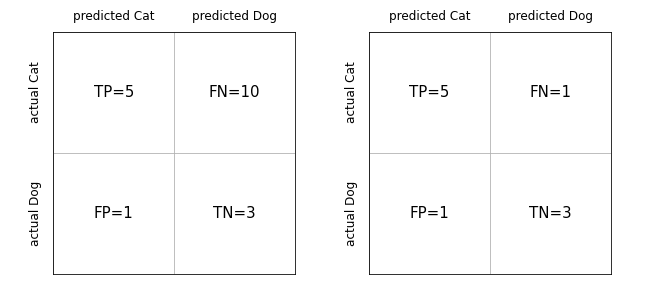

In [285]:
display(Image('images/confusion_cats.png'))

We have here the same precision on the left and the right $\texttt{precision} = \frac{5}{5+1} = 0.83$. So we have few actual dog pictures that we classify as cats. But what about the recall? On the left, we have $\texttt{recall} = \frac{5}{5+10} = 0.33$. This is bad, we are missing a lot of cat pictures. So those we predict as cats are usually cats, but we miss many of them! On the right, we have a much better result with $\texttt{recall} = \frac{5}{5+1} = 0.83$.

One can define many other such variable. One important one, summarizes precision and recall and is called **F-score**: $F = 2 * \frac{\texttt{precision}\; x \;\texttt{recall}}{\texttt{precision}\; + \;\texttt{recall}}$. In our examples above we get $F=0.47$ on the left and $F=0.83$ on the right.

Depending on the problem, one might prefer maximizing one or the other metric. For example if we think of a covid-test, we would obviously like to try maximizing both precision and recall, but if there are technical trade-offs, we would prefer to detect infectious people all the time (good recall) at the cost of precision (some people will get a positive test even though they are not infectious).

## Metrics in scikit-learn

Of course we get access to all these metrics via scikit-learn. There are specific functions like ```precision_socre``` but we can also get a summary of all values with either ```precision_recall_fscore_support``` or ```classification_report```.

In [341]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support, classification_report


First we redo our classification, once with and once without weights:

In [343]:
log_model_noweight = linear_model.LogisticRegression()
log_model_noweight.fit(X=wine[['volatile acidity']], y=wine['good_bad'])

log_model_weight = linear_model.LogisticRegression()
log_model_weight.fit(X=wine[['volatile acidity']], y=wine['good_bad'], sample_weight=wine['weight']);

predict_data_noweigth = log_model_noweight.predict(wine[['volatile acidity']])
predict_data_weigth = log_model_weight.predict(wine[['volatile acidity']])

Now we compute can look at the reports:

In [344]:
print(classification_report(wine['good_bad'], predict_data_weigth))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       217
           1       0.57      0.75      0.65        63

    accuracy                           0.82       280
   macro avg       0.75      0.79      0.76       280
weighted avg       0.84      0.82      0.83       280



In [345]:
print(classification_report(wine['good_bad'], predict_data_noweigth))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       217
           1       0.79      0.37      0.50        63

    accuracy                           0.84       280
   macro avg       0.82      0.67      0.70       280
weighted avg       0.83      0.84      0.81       280



We see that we get scores for both categories. Again, depending on wehter the outcome is binary (sick, not sick) or not (cats, dogs) we might have interest in having scores for all categories. In the latter case, we can then also look at the average scores like the ```f1-score```. We see in the example above that the macro average F1-score improves when we use weights.

## Exercise

1. Import the King County housing dataset at https://raw.githubusercontent.com/guiwitz/EHML/main/datasets/kc_house_data.csv

2. Create an additional column in the dataset called ```good_bad``` indicating 1 for houses with grades > 7 and 0 otherwise.

3. Use logistic regression to predict ```good_bad``` with ```sqft_living```

4. Find the accuracy of your model.

5. Print a report of the scores of the classification